In [1]:
# Framework con los algoritmos de ML necesarios 
import tensorflow as tf 
import keras

# Funciones necesarias para la arquitectura de la CNN 
from keras.utils import plot_model, to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint


import gym
import cv2 as cv
import matplotlib.pyplot as plt 

import numpy as np 
import pickle

from collections import deque
import random

Using TensorFlow backend.


In [2]:
env = gym.make('KungFuMaster-v0')

print(env.action_space)
# Discrete 14 posibilidades
actions = env.action_space.n

print(env.observation_space)
# una imagen de 210,160,3 shape
dimensions = env.observation_space.shape
print(dimensions)

Discrete(14)
Box(210, 160, 3)
(210, 160, 3)


In [3]:
def modelo(dimensions):
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=dimensions))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    
    model.add(Dense(actions,activation='linear'))
    
    opt = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['accuracy'])
    return model

In [4]:
# originalmente estaba modelo_principal.predict, ahorita vamos a ver 
def predecir_qs(img,modelo):
    return np.argmax(modelo.predict(np.expand_dims(img,0) / 255))

In [5]:
# en base a este contador vamos a saber cuando actualizar los pesos del modelo predictivo
# es decir cada vez que llega a este limite se va a actualizar el modelo de target 
# cada 5 partidas se va a actualizar 
actualizacion_limit = 7
# batch size 
batch_s = 32 
# este valor indica que tanto se aprecian los valores futuros en relacion a los presentes
# si el valor es 1 significa que los valores futuros tienen la misma importancia 
descuento = 0.99

# codigo del entrenamiento, al momento de llegar aqui, venimos del loop principal y lo que ha pasado hasta el 
# momento es que se hizo un step y la informacion de ese step se agrego a la memoria, ahora hay que entrenar 
# dependiendo de la cantidad de valores que hay disponibles.
def train(done_test,actualizacion,save):
    
    # este es el caso en el que no tenemos suficientes datos para obtener de la memoria.
    if len(memory) < batch_s:
        return actualizacion
    
    # obtener el batch que se va a usar de entrenamiento, este se obtiene de manera aleatoria de la memoria 
    batch = random.sample(memory, batch_s)
    
    # obtener imagenes anteriores, estas provienen de la memoria, es decir tendriamos 64 imagenes, se estandarizan
    imagenes_anteriores = np.array([i[0] for i in batch]) / 255
    # los valores de q correspondientes a la parte de la derecha de la ecuacion 
    # lo que hace esto es Q(s,t) en donde s es la imagen actual o pasdas en este caso 
    # a esto tambien se le conoce como los valores de y_pred, el resultado de nuestra prediccion obviamente 
    calidades_actuales = modelo_prediccion.predict(imagenes_anteriores)
    
    # estas son las imagenes nuevas pero igual de cada uno de los elementos del batch 
    imagenes_nuevas = np.array([i[3] for i in batch]) / 255
    # esto corresponde a la parte izquierda de la formula es decir Q(s',t') son las imagenes futuras y se obtiene su calidad
    # sin embargo en este caso tenemos que usar el modelo target porque es el que se va actualizando
    calidades_futuras = modelo_target.predict(imagenes_nuevas)
    
    # iniciar los arreglos que van a tener toda la info para el entrenamiento temporal de la red 
    # x tiene que llevar todas las imagenes anteriores o actuales 
    x = []
    # y tiene que llevar todos los resultados del modelo de target pero junto con el resto de la formula reward + decay * Q'
    y = []
    
    # este loop todavia no es de entrenamiento, solo es de poblar el dataset temporal que es del tamanio del batch
    # toda la info que hay en el enumerate es lo que guardamos anteriormente en la memoria 
    for index, (imagen_actual, action, reward, imagen_nueva, done) in enumerate(batch):
        # si por alguna razon obtenemos un done del batch hay que considerar que hacer 
        if not done:
            # si no esta done entonces el valor del target se evalua en base a la formula
            valor_nuevo = reward + (descuento * np.max(calidades_futuras[index]))
        else:
            # de lo contrario no va haber imagen futura entonces el reward es el mismo que el valor 
            valor_nuevo = reward 
        
        # obtener las calidades correspondientes al step actual, seria un listado de resultados anteriores 
        # cada uno de estos listados va a tener un listado de la cantidad de acciones que hay 14 para kung fu 
        calidades_actuales_temp = calidades_actuales[index]
        # ya que tenemos las calidades temporales pues obviamente hay que actualizar la de la accion que se tomo
        # por lo tanto en action cambia al valor nuevo que se utilizo 
        calidades_actuales_temp[action] = valor_nuevo
        
        # agregar la imagen actual de cada estado del batch a x igual con su normalizacion 
        x.append(imagen_actual / 255)
        # agregar las calidades de esa imagen, la diferencia es que como esto es el target 
        # aunque diga actuales sabemos que la accion de esta se cambio en base a las calidades del futuro
        y.append(calidades_actuales_temp)
        
    # entrenar el modelo en base a lo que acabamos de poblar en el dataset temporal 
    # lo vamos a entrenar cada vez que termina una partida si no estariamos entrenandolo demasiadas veces cada 32 steps 
    modelo_prediccion.fit(np.asarray(x), np.asarray(y), batch_size=batch_s,
                         verbose = 0, shuffle=False if done_test else None)
    # verificar si si realizo el entrenamiento o no 
    if done_test:
        # aqui entra si logro entrenar, es decir que termino el juego
        actualizacion += 1
        if actualizacion > actualizacion_limit:
            # en este caso ya nos tocaria actualizar el modelo que hace las predicciones
            actualizacion = 0
            modelo_target.set_weights(modelo_prediccion.get_weights())
    return actualizacion

In [6]:
# cv.resize(img,(64,64))[30:50,5:]
# dimensiones seleccionadas para la parte interesante del juego. 
adhoc_dims = (20,59,1)

# este va a ser el modelo que debe de hacer el fit, es decir entrenamiento
modelo_prediccion = modelo(adhoc_dims)
# este modelo va a ser el que se va actualizar despues de cierta cantidad de iteraciones y hace el predict 
modelo_target = modelo(adhoc_dims)
# los pesos tienen que empezar igual 
modelo_target.set_weights(modelo_prediccion.get_weights())

In [7]:
# Se obtendra una muestra aleatorea de la cantidad de steps y estos se convierten en un batch que se va a entrenar con el modelo principal

# inicializacion de la memoria de iteraciones anteriores, el modelo 
# principal se va a ir entrenando por medio de mini batches que provienen de una 
# muestra aleatoria de la memoria. la cantidad de valores maximo es 20k
memory = deque(maxlen=50000)
# el minimo de valores permitido en la memoria para que se comience hacer el muestreo aleatorio
minimo_memoria = 1000
# cantidad de partidas que el ambiente va a utilizar para realizar el entrenamiento 
episodios = 25000
# punto de decision para explorar o explotar, si el valor es mayor a epsilon entonces 
# exploto mi modelo, de lo contrario exploro nuevos movimientos con una funcion random. 
epsilon = 1
# la cantidad que epsilon va a ir decrementando con el tiempo. 
decay = 0.9995
# estadisticas importantes a tomar en cuenta por episodio
# posteriormente se van a mostrar todas las ganancias, el promedio, maximo y minimo 
# el cumulative reward tambien es importante 

ganancias = []
histories = []
actualizacion = 0
top_mean = 0
save = False

# empieza el loop principal, el for es representativo de cada partida, cada iteracion es un nuevo intento
for i in range(4000,episodios):
    # inicializar las ganancias en 0 para la partida 
    episode_reward = 0
    # inicializar el contador de steps que hay, no necesariamente va a ser un frame 
    step = 1 
    
    # primer imagen a utilizar, aqui ya pasa transformada a la necesidad del juego
    imagen_actual = np.expand_dims(cv.resize(cv.cvtColor(env.reset(), cv.COLOR_RGB2GRAY),(64,64))[30:50,5:],2)
    
    # reiniciar la variable done porque obviamente despues de cada partida sera true
    done = False 
    
    # este es el loop de la partida, cada iteracion es un step, mientras no haya terminado...
    while not done:
        
        # Exploration vs exploitation, en base al valor de epsilon va a hacer alguna de las 2 
        if np.random.random() > epsilon:
            # en este caso va a predecir, es decir, explotar el modelo actual 
            action = predecir_qs(imagen_actual,modelo_prediccion)
        else:
            # en este caso va a explorar, es decir intentar algo random
            action = env.action_space.sample()
        
        env.render()
        # ahora hay que obtener la informacion del step que se esta realizando en base a la accion que predijimos
        imagen_nueva, reward, done, exta_info = env.step(action)
        # hacer la transformacion adhoc de la imagen 
        imagen_nueva = np.expand_dims(cv.resize(cv.cvtColor(imagen_nueva, cv.COLOR_RGB2GRAY),(64,64))[30:50,5:],2)
        # obtener la recompensa de la accion que acabamos de hacer y sumarselo al acumulador de la partida 
        episode_reward += reward 
        
        # ingresar al memory replay la imagen actual, la accion que hicimos, el reward, la imagen nueva y si ya termino o no 
        memory.append((imagen_actual, action, reward, imagen_nueva, done))
        # ENTRENAMIENTO, actualizacion es un contador de actualizacion del modelo de target 
        actualizacion = train(done,actualizacion,save)
        
        # actualizar la imagen con la nueva que devuelve el step
        imagen_actual = imagen_nueva
        step += 1 
    # al terminar la partida ponemos la suma de las recompensas de todas las acciones a un arreglo para su analisis
    ganancias.append(episode_reward)
    if np.mean(np.asarray(ganancias)) > top_mean:
        top_mean = np.mean(np.asarray(ganancias))
        path = "./ModelosKungFu1/modelo3" + str(i) + ".h5"
        modelo_prediccion.save(path)
        print("Mejor modelo guardado en partida #",str(i))
    if i % 500 == 0:
        print("Episodio #",str(i))
    
    # hacer el decay del epsilon para que poco a poco vaya explotando mas al modelo y deje de explorar 
    if epsilon > 0.1:
        epsilon *= decay

Mejor modelo guardado en partida # 4000
Episodio # 4000
Mejor modelo guardado en partida # 4001


KeyboardInterrupt: 

TESTING

In [6]:
# cargar el modelo para prueba
modelt = load_model('./ModelosExternos/modelo129.h5')
opt = keras.optimizers.Adam(learning_rate=0.0001)
modelt.compile(optimizer=opt,
                  loss='mse',
                  metrics=['accuracy'])
#modelt.load_weights("./ModelosFinales/modelo_prediccion2_weights.h5")

#opt = keras.optimizers.RMSprop(learning_rate=0.00025)
#modelt.compile(optimizer=opt,
#                 loss='mse',
#                  metrics=['accuracy'])

In [7]:
np.expand_dims(np.expand_dims(cv.resize(cv.cvtColor(env.reset(), cv.COLOR_RGB2GRAY),(64,64))[30:50,5:],2),0).shape

(1, 20, 59, 1)

In [9]:
next_image = env.reset()
for _ in range(1000):
    env.render()
    next_image = np.expand_dims(np.expand_dims(cv.resize(cv.cvtColor(next_image, cv.COLOR_RGB2GRAY),(64,64))[30:50,5:],2),0)
    next_image, reward, done, info = env.step(np.argmax(modelt.predict(next_image)))
    if done:
        break
env.close()

In [51]:
rewards = pickle.load(open("./ModelosFinales/ganancias4.txt","rb"))
x_axis = [i for i in range(len(rewards))]

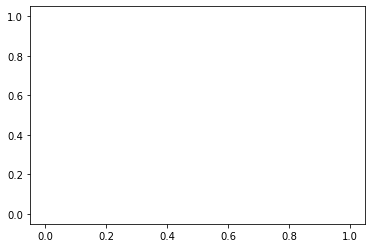

In [52]:
plt.plot(x_axis,rewards)

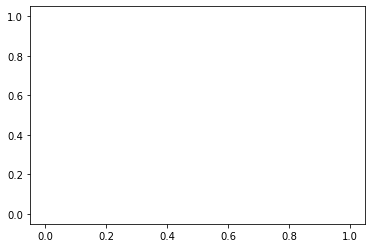

In [53]:
rewards_mean = []
means = []
maxr = []
for i in rewards:
    rewards_mean.append(i)
    means.append(np.mean(np.array(rewards_mean)))
    maxr.append(np.max(np.array(rewards_mean)))
plt.plot(x_axis,means)

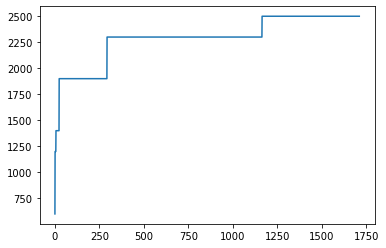

In [50]:
plt.plot(x_axis,maxr)